In [1]:
!python -m pip install tensorflow

In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import mediapipe as mp


In [31]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [33]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color space from BGR to RGB
    image.flags.writeable = False                   # Mark image as not writeable
    results = model.process(image)                  # Process the image and get the results
    image.flags.writeable = True                    # Mark image as writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert color space back to BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw left hand landmarks and connections
    mp_drawing.draw_landmarks(
        image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
    )
    
    # Draw right hand landmarks and connections
    mp_drawing.draw_landmarks(
        image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
    )

def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])


In [34]:
# Path for exported data, numpy arrays
DATA_PATH = r'C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data'

# Actions that we try to detect
actions = np.array(['hello', 'peace'])

# Number of sequences per action
no_sequences = 120

# Sequence length (frames per sequence)
sequence_length = 30

# Starting folder index
start_folder = 30

# Create a mapping of actions to labels
label_map = {label: num for num, label in enumerate(actions)}


In [35]:
sequences, labels = [], []
for action in actions: 
    for sequence in range(start_folder, start_folder + no_sequences):
        # Skip the last folder
        if sequence == start_folder + no_sequences - 1:
            continue
        window = []
        for frame_num in range(sequence_length):
            file_path = os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num))
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            res = np.load(file_path)
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
    print("completed: " + action + "\n")


File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\0.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\1.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\2.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\3.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\4.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\5.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\6.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\7.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\8.npy
File not found: C:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\data\hello\60\9.npy
File not f

In [39]:
# Filter out empty sequences
non_empty_sequences = [seq for seq in sequences if len(seq) == sequence_length]

# Convert the filtered sequences to a NumPy array
try:
    X = np.array(non_empty_sequences)
    print(f"Converted sequences to array with shape: {X.shape}")
except ValueError as e:
    print(f"Error converting sequences to array: {e}")

# Check if all sequences have the same length
sequence_lengths = [len(seq) for seq in non_empty_sequences]
unique_lengths = set(sequence_lengths)

if len(unique_lengths) != 1:
    print(f"Inconsistent sequence lengths detected: {unique_lengths}")
else:
    print(f"All sequences have a consistent length of {sequence_length}.")

# Convert labels to categorical format
# Filter labels to match the filtered sequences
filtered_labels = [labels[i] for i in range(len(sequences)) if len(sequences[i]) == sequence_length]
y = to_categorical(filtered_labels).astype(int)

# Debugging outputs
print(f"Filtered labels length: {len(filtered_labels)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")


Converted sequences to array with shape: (60, 30, 126)
All sequences have a consistent length of 30.
Filtered labels length: 60
X shape: (60, 30, 126), y shape: (60, 2)


In [40]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)


# Building and Training LSTM Neural Network

## Load the model if already saved

In [18]:
from tensorflow import keras
model = keras.models.load_model('action.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'action.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [42]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\aakas\OneDrive\Desktop\Grind\Renjan Master\action_2.0\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [45]:
model.fit(X_train, y_train, epochs=250)

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.5436 - loss: 0.6935
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.4896 - loss: 0.6876
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.5000 - loss: 0.6782
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5228 - loss: 0.6561
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.5436 - loss: 0.5972
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.5143 - loss: 0.4858
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.8615 - loss: 0.3736
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9402 - loss: 0.3586
Epoch 9/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.9298 - loss: 1.8343
Epoch 10/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9525 - loss: 0.2042
Epoch 11/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

# Evaluation

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [47]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


In [48]:
ytrue = np.argmax(y_test, axis=1).tolist()
print(len(ytrue))
yhat = np.argmax(yhat, axis=1).tolist()
print(len(yhat))

6
6


In [49]:
result=np.round(confusion_matrix(ytrue, yhat)/12 ,2)

<Axes: >

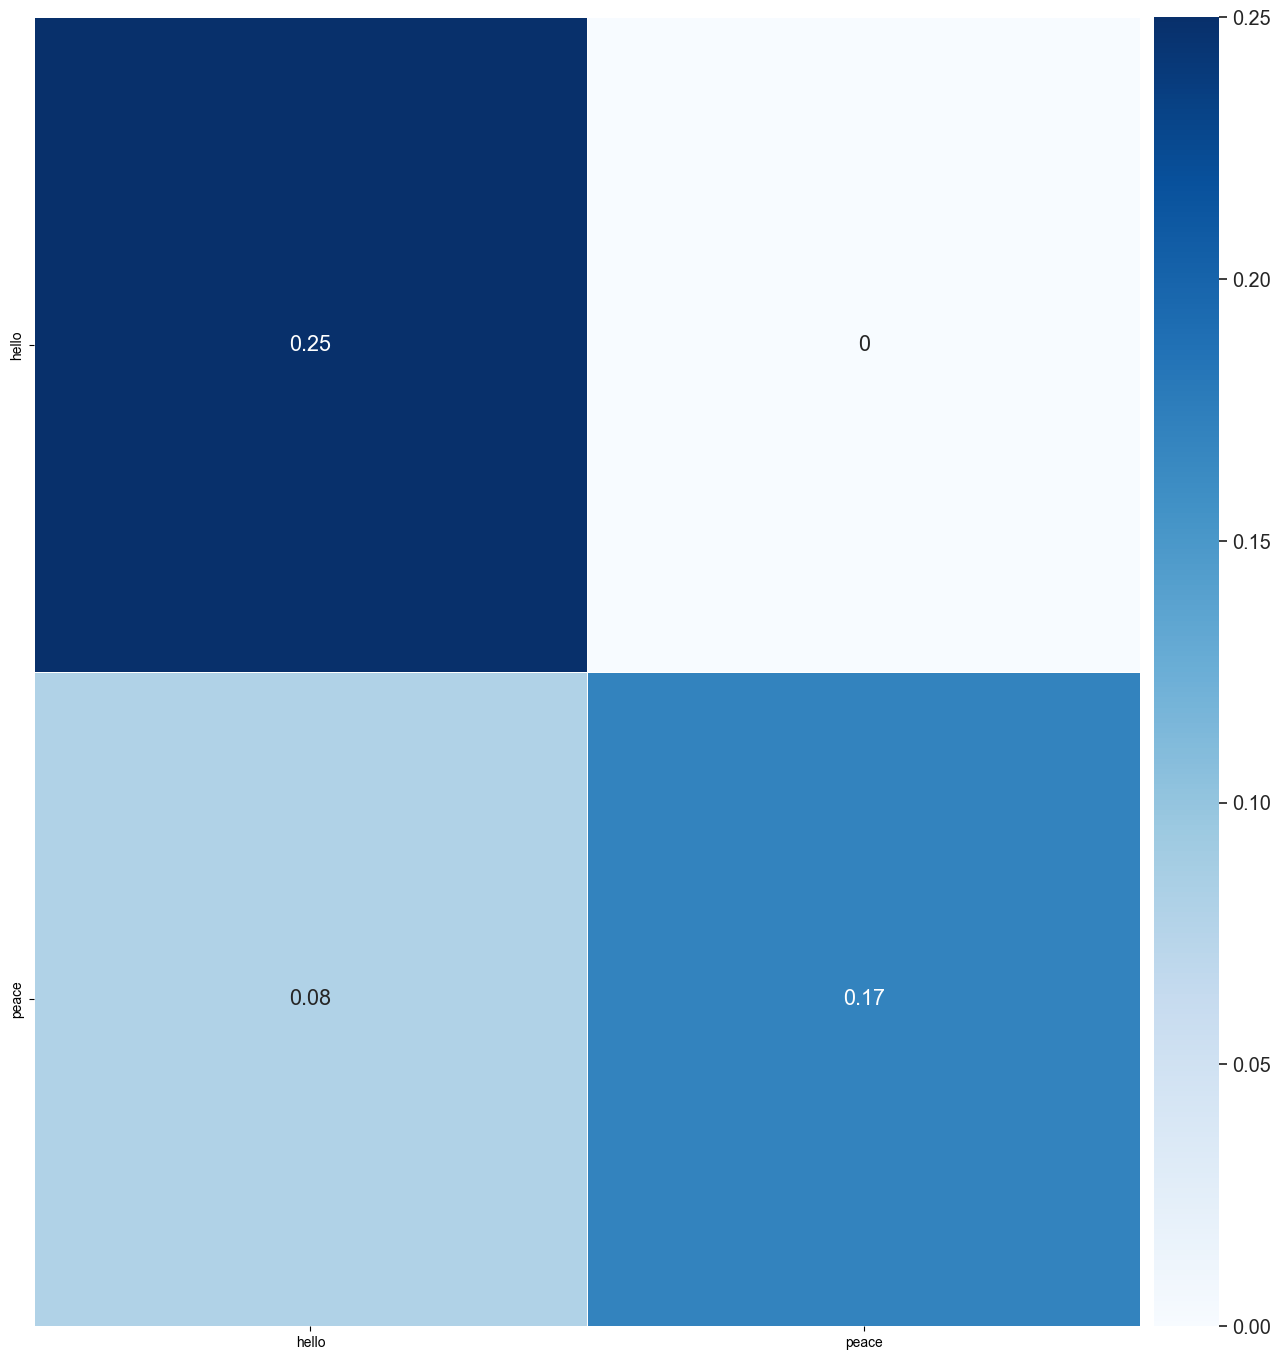

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,17))
sns.set(font_scale=1.3) 
sns.heatmap(result, annot=True, linewidth=.5,xticklabels=actions, yticklabels=actions,cmap="Blues",cbar_kws={"orientation": "vertical", "pad": 0.01})

In [51]:
accuracy_score(ytrue, yhat)

0.8333333333333334

In [52]:
model.save('action.h5')

# Test In real Time

In [59]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)

# Function to display image in a separate window
def display(image):
    cv2.imshow('OpenCV Feed', image)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Extract keypoints and update the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        # Only predict if we have enough keypoints (30 frames)
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            prediction = actions[np.argmax(res)]
            confidence = np.max(res)

            # Check confidence threshold
            if confidence > threshold:
                # Append prediction to sentence
                if len(sentence) == 0 or (sentence[-1] != prediction):
                    sentence.append(prediction)

            # Display the last prediction
            cv2.putText(image, ' '.join(sentence), (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show the image in the display window
        display(image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [56]:
cap.release()
cv2.destroyAllWindows()